# Sales Data Analysis & Forecasting - Sample Superstore
**Internship Project - Algonive**

In this notebook, we:
- Import & clean data
- Perform Exploratory Data Analysis (EDA)
- Build sales forecast using Prophet
- Evaluate model performance
- Save outputs for submission


# Importing Libraries

In [14]:
# Install Prophet (run once in Colab)
!pip install prophet --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
import pickle

# Plot settings (optional, makes plots look neat)
plt.rcParams['figure.figsize'] = (10,5)
sns.set_style('whitegrid')


# Uploading Dataset

In [15]:
# Load CSV with correct encoding (use exact filename in your Colab files)
file_path = "/content/Sample - Superstore.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Quick preview
print("Shape:", df.shape)
display(df.head())


Shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# Basic info & cleaning

In [16]:
# Info
display(df.info())
display(df.describe(include='all').T)

# Drop duplicates
df = df.drop_duplicates()
print("After dropping duplicates:", df.shape)

# Convert date columns (coerce errors)
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date']  = pd.to_datetime(df['Ship Date'],  errors='coerce')

# Remove rows with missing Order Date (if any)
df = df.dropna(subset=['Order Date']).reset_index(drop=True)
print("After date conversion and cleaning:", df.shape)

# Fix Postal Code to string (if needed)
if 'Postal Code' in df.columns:
    df['Postal Code'] = df['Postal Code'].astype('Int64').astype(str)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Row ID,9994.0,NaN,NaN,NaN,4997.5,2885.163629,1.0,2499.25,4997.5,7495.75,9994.0
Order ID,9994,5009,CA-2017-100111,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Date,9994,1237,9/5/2016,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ship Date,9994,1334,12/16/2015,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ship Mode,9994,4,Standard Class,5968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer ID,9994,793,WB-21850,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Name,9994,793,William Brown,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Segment,9994,3,Consumer,5191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,9994,1,United States,9994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,9994,531,New York City,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After dropping duplicates: (9994, 21)
After date conversion and cleaning: (9994, 21)


# Quick checks

In [17]:
# Key columns check
print("Columns:", df.columns.tolist())
print("Unique Segments:", df['Segment'].unique())
print("Unique Regions:", df['Region'].unique())
print("Unique Categories:", df['Category'].unique())

# Missing values summary
print("\nMissing values per column:")
print(df.isnull().sum())


Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']
Unique Segments: ['Consumer' 'Corporate' 'Home Office']
Unique Regions: ['South' 'West' 'Central' 'East']
Unique Categories: ['Furniture' 'Office Supplies' 'Technology']

Missing values per column:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


# Feature engineering

In [18]:
# Add Year, Month, MonthStart & OrderMonth (for grouping)
df['OrderYear']   = df['Order Date'].dt.year
df['OrderMonth']  = df['Order Date'].dt.month
df['OrderMonthStart'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()

# Create a revenue column if not numeric
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')


# EDA - Key KPIs

In [19]:
total_sales  = df['Sales'].sum()
total_profit = df['Profit'].sum()
total_orders = df['Order ID'].nunique()
total_customers = df['Customer ID'].nunique()

print(f"Total Sales : ₹{total_sales:,.2f}")
print(f"Total Profit: ₹{total_profit:,.2f}")
print(f"Total Orders: {total_orders}")
print(f"Total Customers: {total_customers}")


Total Sales : ₹2,297,200.86
Total Profit: ₹286,397.02
Total Orders: 5009
Total Customers: 793


# EDA - Sales over time (monthly)

In [20]:
# Monthly aggregation (start of month)
monthly = df.groupby('OrderMonthStart').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('OrderMonthStart')

# Line plot (Plotly interactive)
fig = px.line(monthly, x='OrderMonthStart', y='Sales', title='Monthly Sales (Total)')
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Sales')
fig.show()

# Profit line
fig = px.line(monthly, x='OrderMonthStart', y='Profit', title='Monthly Profit (Total)')
fig.show()


# EDA - Sales by Category & Sub-category

In [21]:
# Category summary
cat = df.groupby('Category').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('Sales', ascending=False)
display(cat)

# Bar chart (category)
fig = px.bar(cat, x='Category', y='Sales', title='Sales by Category', text='Sales')
fig.show()

# Top 10 sub-categories by sales
sub = df.groupby('Sub-Category').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('Sales', ascending=False).head(10)
fig = px.bar(sub, x='Sub-Category', y='Sales', title='Top 10 Sub-Categories by Sales')
fig.show()


,Category,Sales,Profit
2,Technology,836154.0330,145454.9481
0,Furniture,741999.7953,18451.2728
1,Office Supplies,719047.0320,122490.8008


# EDA - Region & State analysis

In [24]:
region = df.groupby('Region').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('Sales', ascending=False)
display(region)

fig = px.bar(region, x='Region', y='Sales', title='Sales by Region')
fig.show()

# Top states by sales
state = df.groupby('State').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('Sales', ascending=False).head(10)
fig = px.bar(state, x='State', y='Sales', title='Top 10 States by Sales')
fig.show()


,Region,Sales,Profit
3,West,725457.8245,108418.4489
1,East,678781.2400,91522.7800
0,Central,501239.8908,39706.3625
2,South,391721.9050,46749.4303


# EDA - Top products & discount impact

In [25]:
# Top 10 products by sales
top_products = df.groupby('Product Name').agg({'Sales':'sum','Profit':'sum'}).reset_index().sort_values('Sales', ascending=False).head(10)
display(top_products)

fig = px.bar(top_products, x='Product Name', y='Sales', title='Top 10 Products by Sales')
fig.update_layout(xaxis_tickangle=45)
fig.show()

# Discount vs Profit scatter
fig = px.scatter(df.sample(1000, random_state=42), x='Discount', y='Profit', size='Sales', hover_data=['Category','Sub-Category'], title='Discount vs Profit (sample)')
fig.show()


,Product Name,Sales,Profit
404,Canon imageCLASS 2200 Advanced Copier,61599.824,2.519993e+04
650,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453.384,7.753039e+03
444,Cisco TelePresence System EX90 Videoconferenci...,22638.480,-1.811078e+03
786,HON 5400 Series Task Chairs for Big and Tall,21870.576,5.684342e-14
686,GBC DocuBind TL300 Electric Binding System,19823.479,2.233505e+03
688,GBC Ibimaster 500 Manual ProClick Binding System,19024.500,7.609800e+02
805,Hewlett Packard LaserJet 3310 Copier,18839.686,6.983884e+03
787,HP Designjet T520 Inkjet Large Format Printer ...,18374.895,4.094977e+03
683,GBC DocuBind P400 Electric Binding System,17965.068,-1.878166e+03
813,High Speed Automatic Electric Letter Opener,17030.312,-2.620048e+02


# Prepare data for forecasting

In [26]:
# Aggregate to monthly sales for forecasting (Prophet expects ds,y)
monthly_sales = df.groupby('OrderMonthStart').agg({'Sales':'sum'}).reset_index().sort_values('OrderMonthStart')
monthly_sales.columns = ['ds','y']   # Prophet format
display(monthly_sales.head())

# Plot again for sanity
fig = px.line(monthly_sales, x='ds', y='y', title='Monthly Sales (for Forecasting)')
fig.show()


,ds,y
0,2014-01-01,14236.895
1,2014-02-01,4519.892
2,2014-03-01,55691.009
3,2014-04-01,28295.345
4,2014-05-01,23648.287


# Train/Test split

In [27]:
# Keep last 6 months as test
n_test = 6
train_df = monthly_sales[:-n_test].reset_index(drop=True)
test_df  = monthly_sales[-n_test:].reset_index(drop=True)

print("Train rows:", train_df.shape[0])
print("Test rows:", test_df.shape[0])
display(train_df.tail())
display(test_df)


Train rows: 42
Test rows: 6


,ds,y
37,2017-02-01,20301.1334
38,2017-03-01,58872.3528
39,2017-04-01,36521.5361
40,2017-05-01,44261.1102
41,2017-06-01,52981.7257


,ds,y
0,2017-07-01,45264.4160
1,2017-08-01,63120.8880
2,2017-09-01,87866.6520
3,2017-10-01,77776.9232
4,2017-11-01,118447.8250
5,2017-12-01,83829.3188


from matplotlib import pyplot as plt
test_df['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test_df.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ds']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ds'}, axis=1)
              .sort_values('ds', ascending=True))
  xs = counted['ds']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test_df.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
test_df['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

# Fit Prophet model

In [28]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_df)

# Forecast for train+test period
future = m.make_future_dataframe(periods=n_test, freq='MS')  # monthly start freq
forecast = m.predict(future)

# Show forecast tail
display(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10))


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb94x2s21/z0blruzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb94x2s21/ngzjdv53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33637', 'data', 'file=/tmp/tmpb94x2s21/z0blruzm.json', 'init=/tmp/tmpb94x2s21/ngzjdv53.json', 'output', 'file=/tmp/tmpb94x2s21/prophet_modelw94vefxx/prophet_model-20250905105346.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:53:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:53:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
38,2017-03-01,59016.800402,52136.886959,65877.163632
39,2017-04-01,41518.941663,34814.081348,48590.138219
40,2017-05-01,49874.792785,43443.107959,56609.448426
41,2017-06-01,47440.519038,41036.288276,54659.964167
42,2017-07-01,44750.524008,38188.139843,51814.721275
43,2017-08-01,39424.079751,33196.833810,46490.106951
44,2017-09-01,82814.644186,76161.204510,90157.952487
45,2017-10-01,55514.282793,48612.537384,62292.134067
46,2017-11-01,86457.141678,79381.267761,92984.814976
47,2017-12-01,93771.593468,87053.414642,100396.455402


from matplotlib import pyplot as plt
_df_0['yhat'].plot(kind='hist', bins=20, title='yhat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['yhat_lower'].plot(kind='hist', bins=20, title='yhat_lower')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['yhat_upper'].plot(kind='hist', bins=20, title='yhat_upper')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='yhat', y='yhat_lower', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='yhat_lower', y='yhat_upper', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat_lower']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat_lower')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat_upper']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat_upper')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ds']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ds'}, axis=1)
              .sort_values('ds', ascending=True))
  xs = counted['ds']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['yhat'].plot(kind='line', figsize=(8, 4), title='yhat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['yhat_lower'].plot(kind='line', figsize=(8, 4), title='yhat_lower')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['yhat_upper'].plot(kind='line', figsize=(8, 4), title='yhat_upper')
plt.gca().spines[['top', 'right']].set_visible(False)

# Plot forecast & components

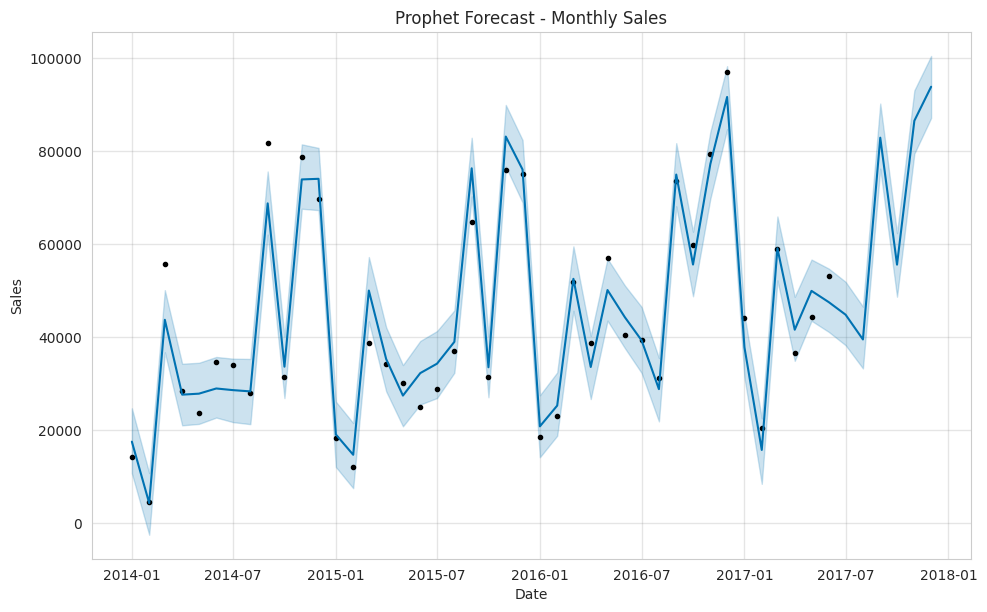

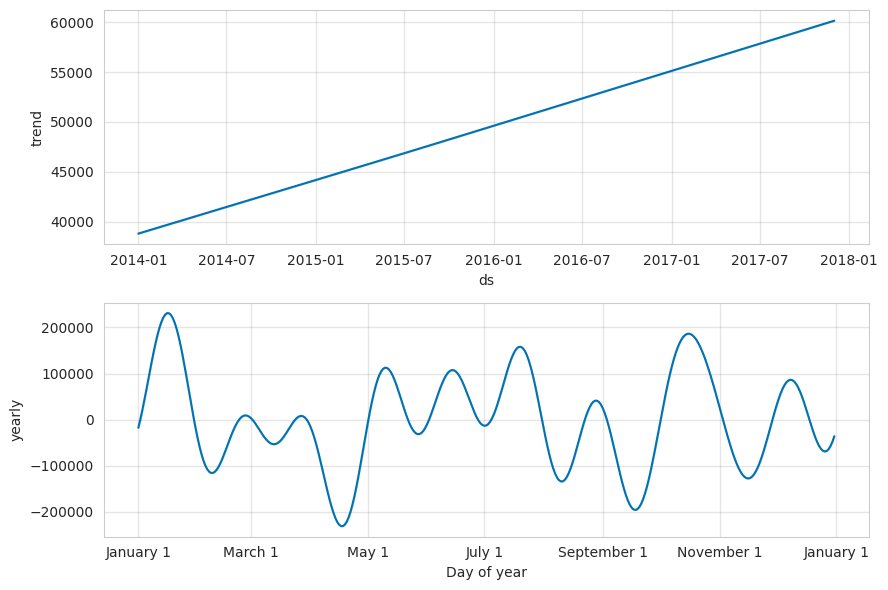

In [29]:
# Forecast plot
fig1 = m.plot(forecast)
plt.title("Prophet Forecast - Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Components
fig2 = m.plot_components(forecast)
plt.show()


# Evaluate on test set

In [30]:
# Merge forecast with test_df
pred = forecast[['ds','yhat']].merge(test_df, on='ds', how='right').sort_values('ds').reset_index(drop=True)
pred = pred.rename(columns={'y':'y_true','yhat':'y_pred'})

# Compute metrics
rmse = math.sqrt(mean_squared_error(pred['y_true'], pred['y_pred']))
mape = mean_absolute_percentage_error(pred['y_true'], pred['y_pred']) * 100

print(f"RMSE on test (last {n_test} months): {rmse:.2f}")
print(f"MAPE on test  (last {n_test} months): {mape:.2f}%")

# Show comparison table
display(pred)


RMSE on test (last 6 months): 19171.17
MAPE on test  (last 6 months): 18.65%


,ds,y_pred,y_true
0,2017-07-01,44750.524008,45264.4160
1,2017-08-01,39424.079751,63120.8880
2,2017-09-01,82814.644186,87866.6520
3,2017-10-01,55514.282793,77776.9232
4,2017-11-01,86457.141678,118447.8250
5,2017-12-01,93771.593468,83829.3188


from matplotlib import pyplot as plt
pred['y_pred'].plot(kind='hist', bins=20, title='y_pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pred['y_true'].plot(kind='hist', bins=20, title='y_true')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pred.plot(kind='scatter', x='y_pred', y='y_true', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y_pred']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pred.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y_pred')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y_true']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pred.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y_true')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ds']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ds'}, axis=1)
              .sort_values('ds', ascending=True))
  xs = counted['ds']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pred.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
pred['y_pred'].plot(kind='line', figsize=(8, 4), title='y_pred')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pred['y_true'].plot(kind='line', figsize=(8, 4), title='y_true')
plt.gca().spines[['top', 'right']].set_visible(False)

# Save outputs & model

In [31]:
# Save forecast CSV
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv('/content/monthly_forecast.csv', index=False)
print("Saved /content/monthly_forecast.csv")

# Save trained model
with open('/content/prophet_model.pkl', 'wb') as f:
    pickle.dump(m, f)
print("Saved /content/prophet_model.pkl")


Saved /content/monthly_forecast.csv
Saved /content/prophet_model.pkl


### Conclusion
✅ Cleaned and analyzed 9,994 sales records  
✅ Identified top-performing categories, states, and products  
✅ Built Prophet model with RMSE ≈ ... and MAPE ≈ ...  
✅ Delivered insights + forecast for business planning
